# Batch Chemical Process


## Problem Statement

Schultheisz, Daniel, and Jude T. Sommerfeld. "Discrete-Event Simulation in Chemical Engineering." Chemical Engineering Education 22.2 (1988): 98-102.

![Batch Process](figures/BatchProcess.png)

    "... a small, single-product batch chemical plant has three identical reactors in parallel, followed by a single storage tank and a batch still. Customer orders (batches) to be filled (which begin with processing in the reactor) occur every 115 ± 30 minutes, uniformly distributed. The reaction time in a given reactor is 335 ± 60 minutes, and the distillation time in the still is 110 ± 25 minutes, both times uniformly distributed. The holding capacity of the storage tank is exactly one batch. Hence, the storage tank must be empty for a given reactor to discharge its batch; if not, the reactor cannot begin processing a new batch until the storage tank becomes empty. The simulation is to be run for 100 batches. The model should have the capability to collect waiting line statistics for the queue immediately upstream of the reactor.""
    
    
You have been hired by the client as a consulting engineer. Prepare a SimPy simulation of this process to deliver to the client. The delivery should include functions to report the key performance indicators, visualize the results of the simulation, and to conduct 'what-if' studies to determine ways to improve process performance.

## Analysis

1. What is the purpose of the simulation? What question needs to be answered? In thinking about this, carefully consider what has been requested, what other questions are relevant to improving system performance.

2. What are the key performance indicators?  What data needs to be collected?

3. What simulation objects should be created for this application?

4. What classes of shared resources will be used in this model?

## Simpy Shared Resources

* **[Resources](https://simpy.readthedocs.io/en/latest/api_reference/simpy.resources.html#module-simpy.resources.resource):** Models resources that are shared among mulitple processes. There is no distinction among items. You request use of a resource and then wait on availability. When the resource becomes available, you continue your process. As some point you can release the resource for use by other processes. You can specify the number of resources available, monitor the number in use, and there are provisions to assign prioriity for processes and to preempt lower priority processes. Useful if you don't need to distinguish which item is in use.

* **[Containers](https://simpy.readthedocs.io/en/latest/api_reference/simpy.resources.html#module-simpy.resources.container):** Like Resources, but for bulk homogeneous goods. Great for modeling use or production of materials.

* **[Stores](https://simpy.readthedocs.io/en/latest/api_reference/simpy.resources.html#module-simpy.resources.store):** Models the production and consumption of objects. The objects don't have to be the same, and can be represented by arbitrary Python objects.  Good for queues where objects must be treated as individual items. You can specify capacity, and used `.put()` and `.get()` to access items. You can get a list of items in the queue with `.items()`. By default, queues operate on a first-in first-out (FIFO) protocol, but other protocols can be implemented using `FilterStore` or `PriorityStore`.

We will use `Stores` to model the various order and equipment queues in this process.


## Generating Customer Orders

>... a small, single-product batch chemical plant has three identical reactors in parallel, followed by a single storage tank and a batch still. **Customer orders (batches) to be filled (which begin with processing in the reactor) occur every 115 $\pm$ 30 minutes, uniformly distributed.** The reaction time in a given reactor iis 335 $\pm$ 60 minutes, and the distillation time in the still is 110 $\pm$ 25 minutes, both times uniformly distributed. The holding capacity of the storage tank is exactly one batch. Hence, the storage tank must be empty for a given reactor to discharge its batch; if not, the reactor cannot begin processing a new batch until the storage tank becomes empty. **The simulation is to be run for 100 batches. The model should have the capability to collect waiting line statistics for the queue immediately upstream of the reactor.**

We begin with modeling the customer order queue. As a first step, we create an outline of the some code that will setup a dictionary to store events associated with each order,

In [1]:
import random
import simpy
import pandas as pd

orders = {}

env = simpy.Environment()

env.run()

df = pd.DataFrame(orders).T
display(df)

""


Next we create an order generator.

<AxesSubplot:xlabel='Order number', ylabel='Time ordered received.'>

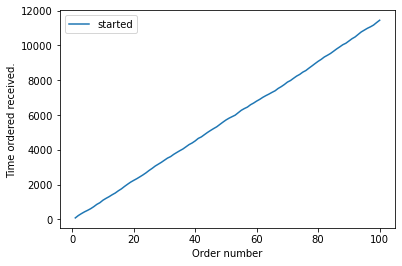

In [9]:
import random
import simpy
import pandas as pd

orders = {}

def order_generator(n_orders=100):
    order_id = 0
    while order_id < n_orders:
        yield env.timeout(random.uniform(115 - 30, 115 + 30))
        order_id += 1
        orders[order_id] = {"started": env.now}

env = simpy.Environment()

env.process(order_generator(100))
env.run()

df = pd.DataFrame(orders).T
df.plot(xlabel="Order number", ylabel="Time ordered received.")

## Order Processor

>... a small, single-product batch chemical plant has three identical reactors in parallel, followed by a single storage tank and a batch still. Customer orders (batches) to be filled (which begin with processing in the reactor) occur every 115 $\pm$ 30 minutes, uniformly distributed. **The reaction time in a given reactor iis 335 $\pm$ 60 minutes,** and the distillation time in the still is 110 $\pm$ 25 minutes, both times uniformly distributed. **The holding capacity of the storage tank is exactly one batch. Hence, the storage tank must be empty for a given reactor to discharge its batch; if not, the reactor cannot begin processing a new batch until the storage tank becomes empty.** The simulation is to be run for 100 batches. The model should have the capability to collect waiting line statistics for the queue immediately upstream of the reactor.

As a first step we create a set of Stores to contain the reactor, storage tank, and still resources. Although the problem only specifiies one tank and one still, we anticipate the need for "what if" questions to address ways to increase process throughput using capital expenditures.

<AxesSubplot:xlabel='Order number', ylabel='Time ordered received.'>

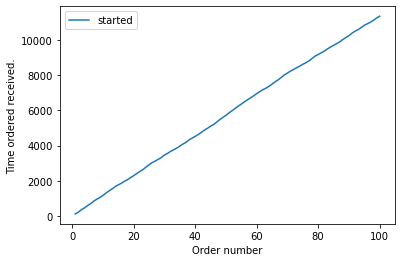

In [10]:
import random
import simpy
import pandas as pd

orders = {}

def order_generator(n_orders=100):
    order_id = 0
    while order_id < n_orders:
        yield env.timeout(random.uniform(115 - 30, 115 + 30))
        order_id += 1
        orders[order_id] = {"started": env.now}
        
env = simpy.Environment()

reactors = simpy.Store(env)
reactors.items = ["Reactor A", "Reactor B", "Reactor C"]

tanks = simpy.Store(env)
tanks.items = ["Tank A"]

stills = simpy.Store(env)
stills.time = ["Still A"]

env.process(order_generator(100))
env.run()

df = pd.DataFrame(orders).T
df.plot(xlabel="Order number", ylabel="Time ordered received.")

Next we add an order processor. An order processor is created for each order to marshall the equipment needed to process the order.

<AxesSubplot:xlabel='Order number', ylabel='Time ordered received.'>

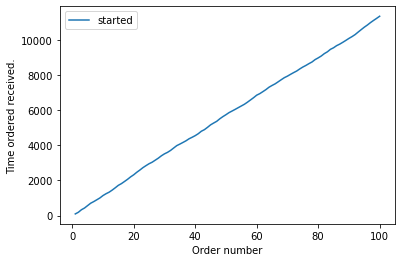

In [44]:
import random
import simpy
import pandas as pd

orders = {}

def order_generator(n_orders=100):
    order_id = 0
    while order_id < n_orders:
        yield env.timeout(random.uniform(115 - 30, 115 + 30))
        order_id += 1
        orders[order_id] = {"started": env.now}
        
def order_processor(order_id):
    
    reactor = yield reactors.get()
    orders[order_id]["reaction started"] = env.now
    yield env.timeout(random.uniform(335 - 60, 335 + 60))
    orders[order_id]["reaction finished"] = env.now

    tank = yield tanks.get()
    orders[order_id]["storage started"] = env.now
    reactors.put(reactor)

    still = yield stills.get()
    orders[order_id]["still started"] = env.now
    yield env.timeout(random.uniform(110 - 20, 110 + 20))

    orders[order_id]["finished"] = env.now
    stills.put(still)
    tanks.put(tank)     
        
env = simpy.Environment()

reactors = simpy.Store(env)
reactors.items = ["Reactor A", "Reactor B", "Reactor C"]

tanks = simpy.Store(env)
tanks.items = ["Tank A"]

stills = simpy.Store(env)
stills.items = ["Still A"]

env.process(order_generator(100))
env.run()

df = pd.DataFrame(orders).T
df.plot(xlabel="Order number", ylabel="Time ordered received.")

The final step is to create a Simpy process to handle individual order as they arrive to the plant. We do this in the order generator. For coding convenience, we move the all of the recording functions to the order processor.

<AxesSubplot:xlabel='Order number', ylabel='Time ordered received.'>

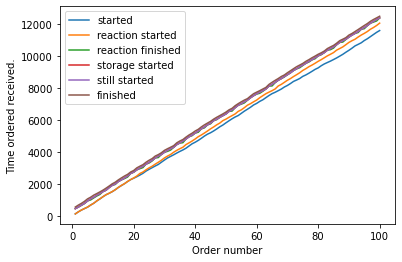

In [59]:
import random
import simpy
import pandas as pd

orders = {}

def order_generator(n_orders=100):
    order_id = 0
    while order_id < n_orders:
        yield env.timeout(random.uniform(115 - 30, 115 + 30))
        order_id += 1
        env.process(order_processor(order_id))
        
def order_processor(order_id):
    
    orders[order_id] = {"started": env.now}
    
    reactor = yield reactors.get()
    orders[order_id]["reaction started"] = env.now
    
    yield env.timeout(random.uniform(335 - 60, 335 + 60))
    orders[order_id]["reaction finished"] = env.now

    tank = yield tanks.get()
    orders[order_id]["storage started"] = env.now
    reactors.put(reactor)

    still = yield stills.get()
    orders[order_id]["still started"] = env.now
    yield env.timeout(random.uniform(110 - 20, 110 + 20))

    orders[order_id]["finished"] = env.now
    stills.put(still)
    tanks.put(tank)     
        
env = simpy.Environment()

reactors = simpy.Store(env)
reactors.items = ["Reactor A", "Reactor B", "Reactor C"]

tanks = simpy.Store(env)
tanks.items = ["Tank A"]

stills = simpy.Store(env)
stills.items = ["Still A"]

env.process(order_generator(100))
env.run()

df = pd.DataFrame(orders).T
df.plot(xlabel="Order number", ylabel="Time ordered received.")

## Analysis

To facilitate analysis, we do some post-processing of the simulation data. Here we subtract the start time for each order from all of the other data to track the progress of orders through the process. 

Most, but not all, runs of the simulation show elapsed times that increase for later arriving orders. In statistical terms, this is an example of "non-stationary" behavior. In other words, waiting times within the process are increasinig over time. This is highly undesireable behavior indicating the presence of a process "bottleneck".

In the case, it appears orders are waiting for an available reactor. What process modifications would you recommend to accommodate the flow of orders to this plant?

<AxesSubplot:title={'center':'Elapsed Times'}>

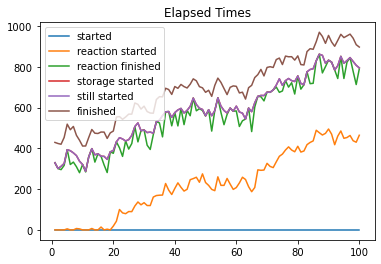

In [60]:
start_times = df["started"]
df.sub(start_times, axis=0).plot(title="Elapsed Times")

## Completed Model

To facilitate "what-if" analyses, we consolidate the code into a single function performiing all required computations. A UI could be added if this were a project to be delivered to client.

['Reactor 0', 'Reactor 1', 'Reactor 2']


started                0.000000
reaction started     206.379627
reaction finished    538.974524
storage started      563.274733
still started        563.274733
finished             673.423873
dtype: float64

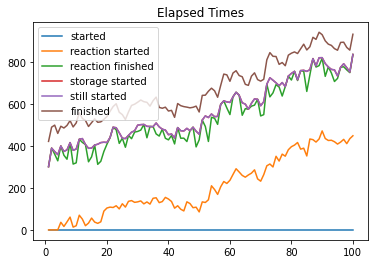

In [103]:
import random
import simpy
import pandas as pd

def simulation(
        order_times = [115-30, 115+30],
        reaction_times = [335-60, 335+60],
        still_times = [110-20, 110+20],
        n_orders = 100,
        n_reactors = 3,
        n_tanks = 1,
        n_stills = 1): 
    
    orders = {}

    def order_generator(n_orders=n_orders):
        order_id = 0
        while order_id < n_orders:
            yield env.timeout(random.uniform(*order_times))
            order_id += 1
            env.process(order_processor(order_id))

    def order_processor(order_id):

        orders[order_id] = {"started": env.now}

        reactor = yield reactors.get()
        orders[order_id]["reaction started"] = env.now

        yield env.timeout(random.uniform(*reaction_times))
        orders[order_id]["reaction finished"] = env.now

        tank = yield tanks.get()
        orders[order_id]["storage started"] = env.now
        reactors.put(reactor)

        still = yield stills.get()
        orders[order_id]["still started"] = env.now
        yield env.timeout(random.uniform(*still_times))

        orders[order_id]["finished"] = env.now
        stills.put(still)
        tanks.put(tank)     

    env = simpy.Environment()

    reactors = simpy.Store(env)
    reactors.items = [f"Reactor {n}" for n in range(0, n_reactors)]
    print(reactors.items)

    tanks = simpy.Store(env)
    tanks.items = [f"Tank {n}" for n in range(0, n_tanks)]
    
    stills = simpy.Store(env)
    stills.items = [f"Still {n}" for n in range(0, n_stills)]

    env.process(order_generator(n_orders))
    env.run()

    df = pd.DataFrame(orders).T
    start_times = df["started"]
    elapsed_times = df.sub(start_times, axis=0)
    elapsed_times.plot(title="Elapsed Times")
    display(elapsed_times.mean())
    
simulation(n_orders=100, n_reactors=3, n_tanks=1, n_stills=1)

## Tuning the process

['Reactor 0', 'Reactor 1', 'Reactor 2', 'Reactor 3']


started                0.000000
reaction started       0.002531
reaction finished    335.096675
storage started      335.212029
still started        335.212029
finished             445.781649
dtype: float64

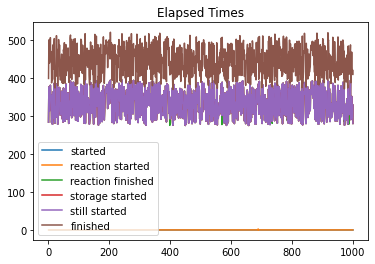

In [104]:
simulation(n_orders=1000, n_reactors=4, n_tanks=2, n_stills=2)